### 导入库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### 读入数据
#### 增加标题列

#### dfu为用户表数据、dfi为项目表数据

In [2]:
##数据表A
df1= pd.read_table('tianchi_fresh_comp_train_user_online_partA.txt')
df1.loc[-1] = df1.columns.tolist()
df1.index = df1.index + 1
df1.sort_index(inplace=True)
df1.columns = ['user_id', 'item_id', 'behavior_type', 'user_geohash', 'item_category', 'time']
##数据表B
df2= pd.read_table('tianchi_fresh_comp_train_user_online_partB.txt')
df2.loc[-1] = df2.columns.tolist()
df2.index = df2.index + 1
df2.sort_index(inplace=True)
df2.columns = ['user_id', 'item_id', 'behavior_type', 'user_geohash', 'item_category', 'time']
dfu = pd.concat([df1, df2])

##项目表
dfi= pd.read_table('tianchi_fresh_comp_train_item_online.txt')
dfi.loc[-1] = dfi.columns.tolist()
dfi.index = dfi.index + 1
dfi.sort_index(inplace=True)
dfi.columns = [ 'item_id', 'item_geohash', 'item_category']

### 探查数据样式

In [26]:
a=dfu.head(100000)

In [33]:
dfi.head(10)

,item_id,item_geohash,item_category
0,100014006,Unnamed: 1,3064
1,100030948,NaN,10544
2,100037683,NaN,12067
3,100039010,NaN,10501
4,100040963,NaN,3960
5,100051766,NaN,2284
6,100059164,NaN,10120
7,100061067,NaN,5801
8,100065317,NaN,10120
9,100072758,NaN,8698


In [34]:
dfu.shape

(9509274, 6)

In [35]:
dfi.shape

(6781009, 3)

# 第一步、 查看缺失值，由于缺失值集中且比例太大，先不考虑地理位置信息了

In [36]:
((dfu.isnull().sum())/dfu.shape[0]).sort_values(ascending=False).map(lambda x:"{:.2%}".format(x))

user_geohash     68.13%
user_id           0.00%
item_id           0.00%
behavior_type     0.00%
item_category     0.00%
time              0.00%
dtype: object

In [37]:
((dfi.isnull().sum())/dfi.shape[0]).sort_values(ascending=False).map(lambda x:"{:.2%}".format(x))

item_geohash     87.86%
item_id           0.00%
item_category     0.00%
dtype: object

### 描述性统计

In [38]:
print(dfu.describe())
print(dfi.describe())

         user_id    item_id  behavior_type user_geohash  item_category  \
count    9509274    9509274        9509274      3030656        9509274   
unique      7944    2388834              5       464225           8674   
top     80499452  112921337              1      99b97l2           1863   
freq      171828       1137        8965161          721         321433   

                 time  
count         9509274  
unique            746  
top     2014-12-11 22  
freq            41704  
          item_id item_geohash  item_category
count     6781009       823271        6781009
unique    6052459       141856           1439
top     335047848      96kajlv           6648
freq        14717          558         225022


# 第二步、查看用户的行为类型， 包括浏览、收藏、加购物车、购买 占比，这里正负样本比例严重失调，可以考虑减少一部分负样本

In [39]:
print(len(dfu[dfu["behavior_type"] == 1])/len(dfu)) # 浏览
print(len(dfu[dfu["behavior_type"] == 2])/len(dfu)) # 收藏
print(len(dfu[dfu["behavior_type"] == 3])/len(dfu)) # 加购物车
print(len(dfu[dfu["behavior_type"] == 4])/len(dfu)) # 购买

0.9427808053485471
0.019504012609164484
0.028030951679381622
0.009684020041908561


### 正样本太少，可以从点击中抽取部分删除

### 转换时间类型

In [58]:
print(df1["time"])

0          2014-11-24 19
1          2014-11-25 20
2          2014-12-06 23
3          2014-12-17 20
4          2014-12-17 17
               ...      
4482231    2014-11-30 22
4482232    2014-11-30 13
4482233    2014-11-29 14
4482234    2014-11-29 13
4482235                2
Name: time, Length: 4482236, dtype: object


In [64]:
df1['time'] = df1['time'].map(str) 

In [73]:
dfu['time'] = pd.to_datetime(dfu['time'], format='%Y%m%d %H',errors = 'coerce')


In [74]:
print(dfu.time)

0         2014-11-24 19:00:00
1         2014-11-25 20:00:00
2         2014-12-06 23:00:00
3         2014-12-17 20:00:00
4         2014-12-17 17:00:00
                  ...        
5027033   2014-12-12 00:00:00
5027034   2014-12-12 11:00:00
5027035   2014-11-21 21:00:00
5027036   2014-12-04 23:00:00
5027037                   NaT
Name: time, Length: 9509274, dtype: datetime64[ns]


In [80]:
dfu["date"] = dfu["time"].dt.date
dfu["weekday"] = dfu["time"].dt.weekday
dfu["hour"] = dfu["time"].dt.hour
print(dfu.head())

    user_id    item_id behavior_type user_geohash item_category  \
0  77404236  306224045             1   Unnamed: 3          9023   
1  77404236  321344925             4          NaN          3424   
2  77404236  393135256             1          NaN         11623   
3  77404236  277463747             1          NaN           451   
4  77404236   38563179             1          NaN          8432   

                 time        date  weekday  hour  
0 2014-11-24 19:00:00  2014-11-24      0.0  19.0  
1 2014-11-25 20:00:00  2014-11-25      1.0  20.0  
2 2014-12-06 23:00:00  2014-12-06      5.0  23.0  
3 2014-12-17 20:00:00  2014-12-17      2.0  20.0  
4 2014-12-17 17:00:00  2014-12-17      2.0  17.0  


### 查看用户消费习惯

In [85]:
# 商品每天的购买情况 in_itemlist表示是否特指待预测商品子集的商品
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
# plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
#sns.set(font='SimHei')  # 解决Seaborn中文显示问题

def erveryday_buy_counts(in_itemlist=False):
    if in_itemlist == True:
        condition = dfu["item_id"].isin(item_list)
    else:
        condition = True
    #f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
    item_day_buy_count = dfu[(dfu.behavior_type == 4) & (condition) ][["user_id", "item_id", "date"]].drop_duplicates()#&(condition)]
    item_day_buy_count["buy_count"] = 1
    item_day_buy_count["date"]=item_day_buy_count["date"].apply(lambda x:str(x)[5:])
    item_day_buy_count=item_day_buy_count[['buy_count','date']].groupby('date').count().sort_values('date')
    
    f, ax = plt.subplots(figsize=(20, 5))
    fig=sns.barplot(x=item_day_buy_count.index,y=item_day_buy_count['buy_count'])
    #fig.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #sns.barplotp('')

# 第三步、商品全集每天的购买情况，建议删除12.12

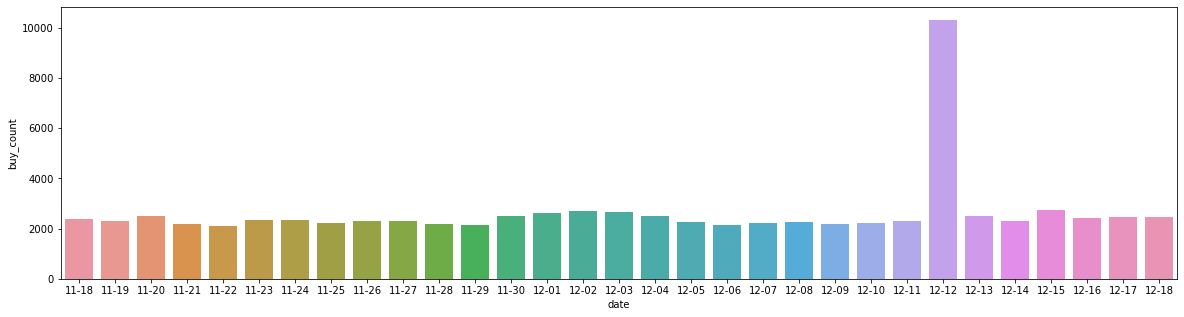

In [86]:
erveryday_buy_counts(in_itemlist=False)

Text(0.5, 1.0, '购买')

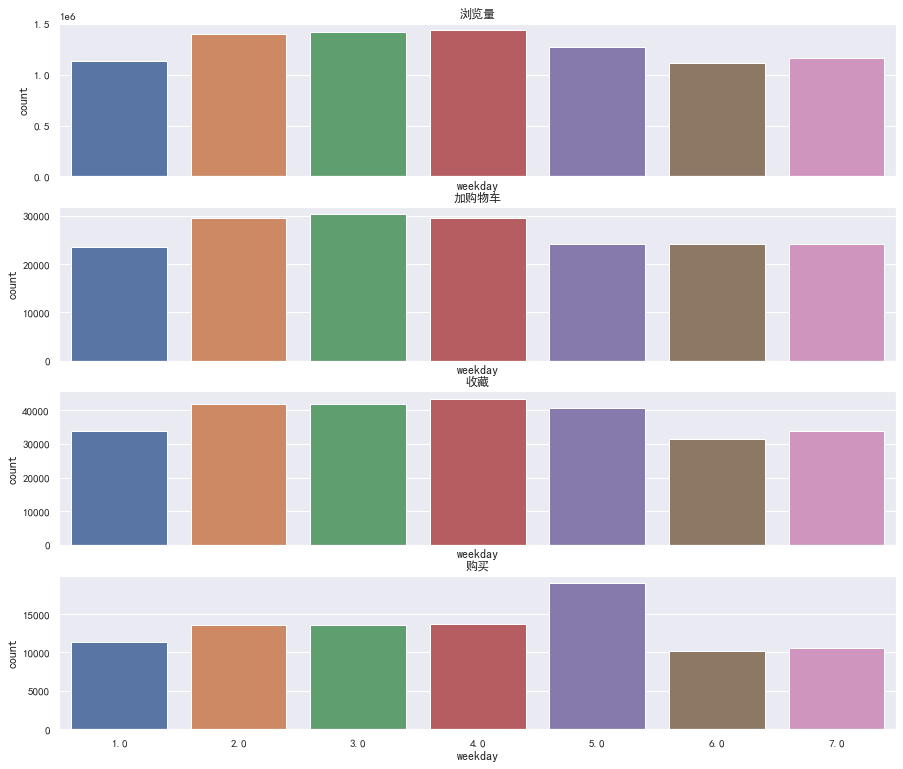

In [94]:
# 用户type操作的星期分布
sns.set(font='SimHei')  # 解决Seaborn中文显示问题
def weekday_buy_counts(type, in_itemlist=False):
    if in_itemlist == True:
        condition = dfu["item_id"].isin(item_list)
    else:
        condition = True
    weekday_buy_counts = dfu[(dfu["behavior_type"] == type)&(condition)][["weekday"]]
    weekday_buy_counts["count"] = 1
    weekday_buy_counts["weekday"] = weekday_buy_counts["weekday"].apply(lambda x: x+1)
    #print(weekday_buy_counts)
    weekday_buy_counts = weekday_buy_counts.groupby("weekday", as_index=False).count().sort_values(by="count", ascending=False).reset_index(drop=True)
    return weekday_buy_counts


f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(15, 13), sharex=True)

# 商品全集 浏览、加购物车、收藏 和买 的星期分布图
data = weekday_buy_counts(1, False)
#print(data.head(7))
fig = sns.barplot(x="weekday", y="count", data=data,ax=ax1) 
ax1.set_title('浏览量')

data = weekday_buy_counts(2, False)
fig = sns.barplot(x="weekday", y="count", data=data,ax=ax2)
ax2.set_title('加购物车')

data = weekday_buy_counts(3, False)
fig = sns.barplot(x="weekday", y="count", data=data,ax=ax3)
ax3.set_title('收藏')
data = weekday_buy_counts(4, False)
fig = sns.barplot(x="weekday", y="count", data=data,ax=ax4)
ax4.set_title('购买')



#上图展示了用户的四种行为在一个星期内每天的分布，浏览、收藏和加入购物车的分布大致相同，而星期五购买量不其他的天数多。

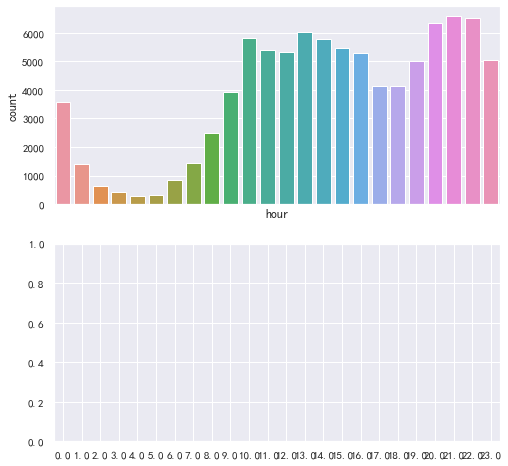

In [102]:
# 用户type操作的时间段分布
def hour_buy_counts(type, in_itemlist=False):
    if in_itemlist == True:
        condition = dfu["item_id"].isin(item_list)
    else:
        condition = True
    hour_buy_counts = dfu[(dfu["behavior_type"] == type)&(condition)][["hour"]]
    hour_buy_counts["count"] = 1
    hour_buy_counts = hour_buy_counts.groupby("hour", as_index=False).count().sort_values(by="count", ascending=False).reset_index(drop=True)
    return hour_buy_counts

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
# 商品全集购买时间段分布图
data = hour_buy_counts(4,False)
fig = sns.barplot(x="hour", y="count", data=data,ax=ax1)

# 第四步、以下步骤可以分离浏览量多而购买量少的顾客，并考虑是否将其筛选出去

In [107]:
dfu[dfu["behavior_type"]==1]

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,weekday,hour
2,77404236,393135256,1,NaN,11623,2014-12-06 23:00:00,2014-12-06,5.0,23.0
3,77404236,277463747,1,NaN,451,2014-12-17 20:00:00,2014-12-17,2.0,20.0
4,77404236,38563179,1,NaN,8432,2014-12-17 17:00:00,2014-12-17,2.0,17.0
5,77404236,135800317,1,NaN,4676,2014-12-17 20:00:00,2014-12-17,2.0,20.0
6,77404236,351904813,1,NaN,3424,2014-11-25 20:00:00,2014-11-25,1.0,20.0
...,...,...,...,...,...,...,...,...,...
5027032,52673428,392968719,1,9qv9lbg,1121,2014-12-17 23:00:00,2014-12-17,2.0,23.0
5027033,52673428,269280095,1,NaN,3660,2014-12-12 00:00:00,2014-12-12,4.0,0.0
5027034,52673428,32768298,1,NaN,11552,2014-12-12 11:00:00,2014-12-12,4.0,11.0
5027036,52673428,9649546,1,9qv9lb3,2513,2014-12-04 23:00:00,2014-12-04,3.0,23.0


#### 统计用户的各行为类型数量

In [3]:
b = dfu.groupby("user_id")['behavior_type'].value_counts().unstack(fill_value=0)
dfu['b'] = dfu.apply(lambda row:b.loc[row['user_id']][row['behavior_type']],axis = 1)
dfu

,user_id,item_id,behavior_type,user_geohash,item_category,time,b
0,77404236,306224045,1,Unnamed: 3,9023,2014-11-24 19,1
1,77404236,321344925,4,NaN,3424,2014-11-25 20,1
2,77404236,393135256,1,NaN,11623,2014-12-06 23,158
3,77404236,277463747,1,NaN,451,2014-12-17 20,158
4,77404236,38563179,1,NaN,8432,2014-12-17 17,158
...,...,...,...,...,...,...,...
5027033,52673428,269280095,1,NaN,3660,2014-12-12 00,148
5027034,52673428,32768298,1,NaN,11552,2014-12-12 11,148
5027035,52673428,83480236,4,9qv9om9,1450,2014-11-21 21,1
5027036,52673428,9649546,1,9qv9lb3,2513,2014-12-04 23,148


In [5]:
grouped = dfu.groupby(['user_id', 'behavior_type']).size().unstack()


In [14]:
filtered = grouped[(grouped[1]>=2000) & (grouped[4]<=3)]


In [15]:
print(filtered.index.tolist())

[7777596, 7918804, 8365383, 8376406, 15221054, 18318131, 19495371, 21850027, 22990112, 23986022, 25843529, 35570616, 64664063, 68049569, 68441681, 68532413, 71816486, 73342548, 74001355, 75153286, 75991984, 77214062, 78877340, 79932737, 80599889, 81810767, 82862011, 83580816, 83717274, 84406602, 84407054, 84963162, 88224709, 88910442, 89578683, 90189143, 90532818, 91477497, 96499150, 100388672, 100587898, 101698285, 101918696, 103124914, 133568246, 134539053, 136372731, 136942161, 138512524, 138915115, 139660465, 140740616, 142343953]
